This is a vision application of the AIRSAS Image Classification study for my thesis. Inputs are in the form of x by x pixel beamformed images from the AIRSAS. Outputs are the predicted letter present in the scan. The training set consists of imagery of 60,000 numbers generated from MATLAB. In this implementation, several key features will be determined from the generated input imagery to make predictions on AIRSAS imagery.

NOTE: This notebook makes use of the fastai library. I included a copy of the library in the folder, but if it still doesn't work run the code cell below to get the necessary files. 

In [1]:
!pip install fastai==2.1.9

     |████████████████████████████████| 194kB 6.5MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


This cell connects to our google drive to access files. *Only necessary if you are running this setup on Colab.*








In [2]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Next, we will need to import all the necessary libraries for this project.

In [3]:
from fastai.vision.all import *
import os
import numpy as np
import random
import pandas as pd
import time
from pathlib import Path
import zipfile as zf
from IPython.display import Image
from PIL import Image, ImageOps

Next, we will allocate the testing parameters for this implementation. Epochs has been set to 100, so the learners will run for 100 epochs. The layer setup has been set to the Fast.AI default, but can be varied. n_classes contains the individual genres that will be tested.

In [4]:
epochs = 100
layers = [200,100,50]
#Full n_classes = ['1','2','3','4','5','6','7','8','9','0']
n_classes =  ['1','2','3','4','5','6','7','8','9','0']
print('Training_layers_' + str(layers[0]) + str(layers[1]) + str(layers[2]) + '_' + '_'.join([str(elem) for elem in n_classes]))

Training_layers_20010050_1_2_3_4_5_6_7_8_9_0


Finally, we will allocate the constants for this implementation. metrics specifies the values our learner model will display per epoch.

In [5]:
metrics = [accuracy,error_rate]

In the next two cells, we will set up the folders needed to organize our input data. Even if the folders are already setup, the first cell must be run in order to allocate the paths used later on.

In [7]:
AIRSAS_Classifier_Data = Path('drive/MyDrive/AIRSAS_Classifier_Data_1000')
Test_Imagery = Path(str(AIRSAS_Classifier_Data) + '/Test_Imagery')
Train_Imagery = Path(str(AIRSAS_Classifier_Data) + '/Train_Imagery')

This cell makes the directories if they don't exist already.

In [8]:
AIRSAS_Classifier_Data.mkdir(parents=True, exist_ok=True)
Test_Imagery.mkdir(parents=True, exist_ok=True)
Train_Imagery.mkdir(parents=True, exist_ok=True)

We now have to allocate training data.  Zip all the test image files in a file titled "Train_numbers.zip".
Run this cell to extract all the files.

In [10]:
files = zf.ZipFile(str(AIRSAS_Classifier_Data) + '/Train_Imagery/Train_numbers.zip', 'r')
files.extractall(str(Train_Imagery))
files.close()
os.remove(str(Train_Imagery) + '/Train_numbers.zip')

I realized that the Matlab script for generated image data was making images that were mirror flipped vertically. Run the next cell to fix this issue. 

In [14]:
for file in os.listdir(Train_Imagery):
  filename = os.fsdecode(file)
  im = Image.open(str(Train_Imagery) + '/' + filename)
  im_flip = ImageOps.flip(im)
  im_flip.save(str(Train_Imagery) + '/' + filename)
  print(filename)

MNIST1_5train_CLEAN.png
MNIST2_0train_CLEAN.png
MNIST3_4train_CLEAN.png
MNIST4_1train_CLEAN.png
MNIST5_9train_CLEAN.png
MNIST6_2train_CLEAN.png
MNIST7_1train_CLEAN.png
MNIST8_3train_CLEAN.png
MNIST9_1train_CLEAN.png
MNIST10_4train_CLEAN.png
MNIST11_3train_CLEAN.png
MNIST12_5train_CLEAN.png
MNIST13_3train_CLEAN.png
MNIST14_6train_CLEAN.png
MNIST15_1train_CLEAN.png
MNIST16_7train_CLEAN.png
MNIST17_2train_CLEAN.png
MNIST18_8train_CLEAN.png
MNIST19_6train_CLEAN.png
MNIST20_9train_CLEAN.png
MNIST21_4train_CLEAN.png
MNIST22_0train_CLEAN.png
MNIST23_9train_CLEAN.png
MNIST24_1train_CLEAN.png
MNIST25_1train_CLEAN.png
MNIST26_2train_CLEAN.png
MNIST27_4train_CLEAN.png
MNIST28_3train_CLEAN.png
MNIST29_2train_CLEAN.png
MNIST30_7train_CLEAN.png
MNIST31_3train_CLEAN.png
MNIST32_8train_CLEAN.png
MNIST33_6train_CLEAN.png
MNIST34_9train_CLEAN.png
MNIST35_0train_CLEAN.png
MNIST36_5train_CLEAN.png
MNIST37_6train_CLEAN.png
MNIST38_0train_CLEAN.png
MNIST39_7train_CLEAN.png
MNIST40_6train_CLEAN.png
MNIST41_1

Next step is to allocate the testing data. Zip all of the output images produced by the beamformer script into an archive titled "Test_numbers.zip". Run this cell to extract all the files.

In [ ]:
files = zf.ZipFile("drive/MyDrive/AIRSAS_Classifier_Data/Test_Imagery/Test_numbers.zip", 'r')
files.extractall("drive/MyDrive/AIRSAS_Classifier_Data/Test_Imagery/")
files.close()
os.remove("drive/MyDrive/AIRSAS_Classifier_Data/Test_Imagery/Test_numbers.zip")

To verify that things are functioning, the next cell will choose a random image from the test set.

In [ ]:
random_image = random.choice(os.listdir('drive/MyDrive/AIRSAS_Classifier_Data/Test_Imagery/'))
random_image_path = "drive/MyDrive/AIRSAS_Classifier_Data/Test_Imagery/" + str(random_image)
print('Random song image is: ' + random_image)

IndexError: ignored

The random image is displayed.

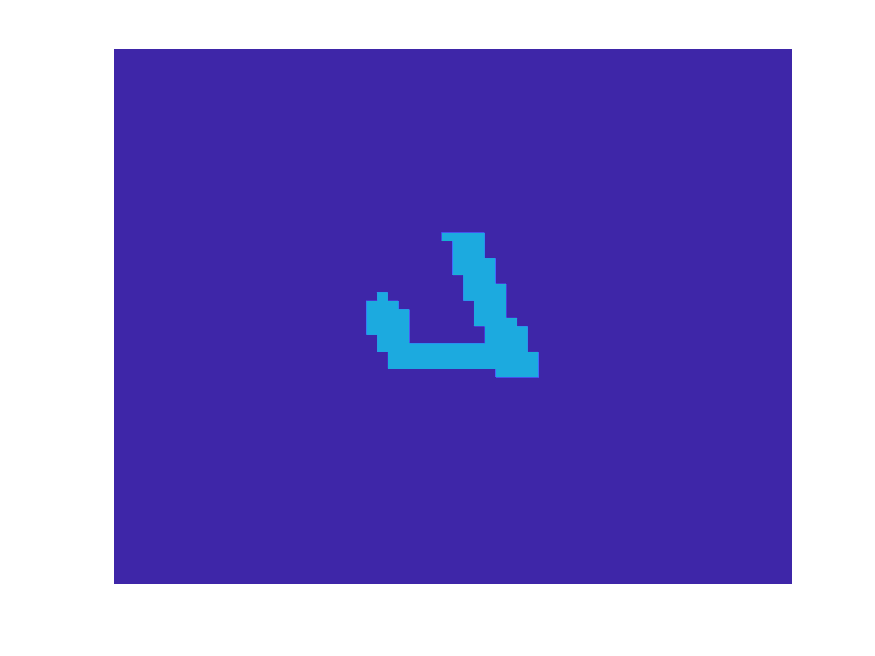

In [ ]:
Image(filename=random_image_path) 

The individual classes or genres to be tested.

In [15]:
classes = n_classes
classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

The next cell will construct the folders for each class that we will sort the training data into.

In [22]:
Sorted_Train_Imagery = Path(str(AIRSAS_Classifier_Data) + '/Sorted_Train_Imagery/')
Sorted_Train_Imagery.mkdir(parents=True, exist_ok=True)

for n in classes:
  folderPath = Path(str(Sorted_Train_Imagery) + '/' + str(n))
  folderPath.mkdir(parents=True, exist_ok=True)

drive/MyDrive/AIRSAS_Classifier_Data_1000/Sorted_Train_Imagery


This cell will sort each image from the training set by file name into their respective folder.

In [25]:
folders = os.listdir(Sorted_Train_Imagery)
for file in os.listdir(Train_Imagery):
  filename = os.fsdecode(file)
  label = filename[-16]
  os.rename(str(Train_Imagery) + '/' + filename, str(Sorted_Train_Imagery)+ '/' + label + '/' + filename)
  print(filename)

MNIST1_5train_CLEAN.png
MNIST2_0train_CLEAN.png
MNIST3_4train_CLEAN.png
MNIST4_1train_CLEAN.png
MNIST5_9train_CLEAN.png
MNIST6_2train_CLEAN.png
MNIST7_1train_CLEAN.png
MNIST8_3train_CLEAN.png
MNIST9_1train_CLEAN.png
MNIST10_4train_CLEAN.png
MNIST11_3train_CLEAN.png
MNIST12_5train_CLEAN.png
MNIST13_3train_CLEAN.png
MNIST14_6train_CLEAN.png
MNIST15_1train_CLEAN.png
MNIST16_7train_CLEAN.png
MNIST17_2train_CLEAN.png
MNIST18_8train_CLEAN.png
MNIST19_6train_CLEAN.png
MNIST20_9train_CLEAN.png
MNIST21_4train_CLEAN.png
MNIST22_0train_CLEAN.png
MNIST23_9train_CLEAN.png
MNIST24_1train_CLEAN.png
MNIST25_1train_CLEAN.png
MNIST26_2train_CLEAN.png
MNIST27_4train_CLEAN.png
MNIST28_3train_CLEAN.png
MNIST29_2train_CLEAN.png
MNIST30_7train_CLEAN.png
MNIST31_3train_CLEAN.png
MNIST32_8train_CLEAN.png
MNIST33_6train_CLEAN.png
MNIST34_9train_CLEAN.png
MNIST35_0train_CLEAN.png
MNIST36_5train_CLEAN.png
MNIST37_6train_CLEAN.png
MNIST38_0train_CLEAN.png
MNIST39_7train_CLEAN.png
MNIST40_6train_CLEAN.png
MNIST41_1

This cell allocates the data into a format used by the Fast.ai

In [26]:
data = ImageDataLoaders.from_folder(Sorted_Train_Imagery, batch_size=2, train=".", valid_pct=0.2, num_workers=0, size = (200,200))

This cell shows an example batch of values in our dataset.

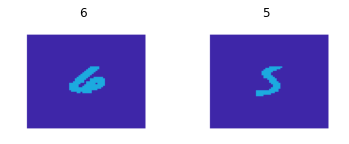

In [27]:
data.show_batch()

This cell allocates our learner model with the layers and metrics we allocated earlier.

In [28]:
learn = cnn_learner(data, resnet34, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


This cell runs the command lr_find(), which will determine some examples for a good learning rate by displaying the learning rate that yeild minimum loss or steepest descent. Either use the default of 3e-3, choose a rate between the two values displayed, or plug the two values into the mean formula below.

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=1.3182567499825382e-06)

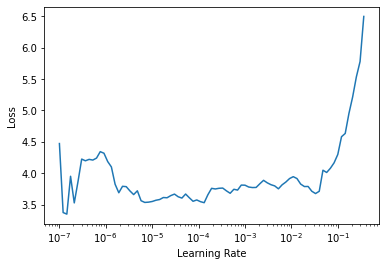

In [29]:
learn.lr_find()

This cell finds the mean between the two learning rate values.

In [30]:
lr_min = 1.3182566908653825e-05
lr_steep = 1.3182567499825382e-06
lr = (lr_min + lr_steep)/2 

This cell fits our learner to the training set for our specified number of epochs. 

In [ ]:
learn.fine_tune(10,lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time


The next cell will show predicted results for our model. Keep in mind all numbers are upside down. 

In [ ]:
learn.show_results()

Finally, we will make predictions on our test data.
This next cell will loop through the test set and compare the prediction scores for each number with the actual quantities of each. Finally, the accuracy will be computed.

In [ ]:
for file in Test_Imagery:]
  number = last character of 
  learn.predict(file)
  score[number]++
  actual[number]++
  if score[number] == actual[number]
    correct++
    
